# Story Generation
We remember things better as stories. The plan here is to pick a subset of our phrases, extract the vocabularly, and generate a story based off of them. We can then pull in more flashcards / phrases to ensure a more complete phrase coverage.

The story name will be story_some_title; when added as a 'tag' into Anki, this will add a hyperlink to a google cloud bucket of a specific format of bucket/language/story_name/story_name.html

This means it is easy to add new stories to an existing flashcard deck, and the links will update as soon as you add the tags

In [29]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()

PAY_FOR_API = True #change to True to run cells that cost money via API calls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import random
from pathlib import Path
from pprint import pprint
from src.config_loader import config
from src.nlp import (
    create_flashcard_index,
    get_vocab_dict_from_dialogue,
    get_vocab_dictionary_from_phrases,
    find_missing_vocabulary,
)
from src.utils import load_json, load_text_file, save_json, save_pickle, upload_to_gcs
from src.anki_tools import get_deck_contents, AnkiCollectionReader
# Add the parent directory of 'src' to the Python path


### Add directories
story images can be re-used between languages, but audio files are language specific, so we structure the story directory story_name/language with audio files in 'language/' and images and the english JSON file in story_name dir

In [3]:
notebook_dir = Path().absolute()  # This gives src/notebooks
phrase_dir = notebook_dir.parent / "data" / "phrases" #where we store text files of phrases
story_dir = notebook_dir.parent / "outputs" / "stories" # where we store our stories

we already have flashcards generated for some phrases:
a flashcard index allows us to select flashcards that cover a specific vocabulary range, it's quite computationally expensive, but is generated
using create_flashcard_index

In [4]:
PHRASE_LIST_NAME = "longman_1000_phrases"
phrase_file = phrase_dir / f"{PHRASE_LIST_NAME}.txt"
phrases = load_text_file(phrase_file)
pprint(f"First few phrases {phrases[:10]}")



("First few phrases ['Do you want to become a famous writer?', 'Let me show "
 "you around the city', 'We need to handle this situation carefully', 'Stop "
 'wasting time on this\', \'Do you like playing the guitar at night?\', "I\'m '
 'taking a vacation next month", "Don\'t forget to wear a helmet while '
 'cycling", "Let\'s cut unnecessary expenses this year", "We\'re producing a '
 'new product soon", \'Did you remember to turn off the stove?\']')


## create the flashcard index
This makes it very fast to find matching flashcards from a given vocab list

In [5]:
# long process, so only create if it doesn't exist
notebook_dir = Path().absolute()  # This gives src/notebooks
index_file = phrase_dir / f"{PHRASE_LIST_NAME}_index.json"

if index_file.exists():
    phrase_index = load_json(index_file)
else:
    phrase_index = create_flashcard_index(phrases)
    save_json(data=phrase_index, file_path=index_file)



## Sample some phrases to generate the story from
This will pin the story to the vocab found in some pre-existing phrases

In [6]:
#we can obtain phrases we know to create a story from:
# NOTE: you must close Anki Desktop when trying to form a connection here
with AnkiCollectionReader() as reader:
    pprint(reader.get_deck_names())

#this will print out deck_id : deck_name -> we want to copy the relevant deck_name

{1: 'Default',
 1731524665442: 'Swedish EAL',
 1732020971325: 'RapidRetention - Swedish - LM1000',
 1732309563077: 'RapidRetention - Dutch - LM1000',
 1732312948269: 'RapidRetention - German - LM1000',
 1732313960891: 'RapidRetention - Arabic - LM1000',
 1732314196963: 'RapidRetention - Spanish - LM1000',
 1732314413500: 'RapidRetention - Japanese - LM1000',
 1732316149591: 'RapidRetention - Russian - LM1000',
 1732316158895: 'RapidRetention - Basque - LM1000',
 1732316821915: 'RapidRetention - French - LM1000',
 1732316936163: 'RapidRetention - Italian - LM1000',
 1732460522330: 'RapidRetention - Persian - LM1000',
 1732465028917: 'RapidRetention - Mandarin Chinese - LM1000',
 1732637740663: 'RapidRetention - Welsh - LM1000',
 1732980361514: 'RapidRetention - Russian - GCSE',
 1732993700879: 'Persian Alphabet',
 1733170456922: 'RapidRetention - Swedish - GCSE',
 1733171641992: 'RapidRetention - Mandarin Chinese - GCSE',
 1734260227418: 'RapidRetention - Swedish - NumbersDays',
 173426

In [7]:
DECK_NAME = "RapidRetention - Swedish - LM1000"
df = get_deck_contents(deck_name=DECK_NAME) #calculates knowledge score
df.head()

,note_id,model_name,tags,n_cards,avg_ease,total_reps,avg_reps,total_lapses,avg_lapses,avg_interval,TargetText,TargetAudio,TargetAudioSlow,EnglishText,WiktionaryLinks,Picture,TargetLanguageName,knowledge_score
0,1732020511348,Language Practice With Images,,3,0.0,0,0.0,0,0.0,0.0,Var mer uppmärksam på detaljer,[sound:a821f020-5a84-44fb-af42-c6c4133e4379.mp3],[sound:3d6997c2-92c7-43c9-b31e-a20cc4f0bf9e.mp3],Pay more attention to details,"<a href=""https://en.wiktionary.org/wiki/var#Sw...","<img src=""f7153993-cfee-40f4-841c-1bd6cfaeb5a9...",Swedish,0.000
1,1732020511352,Language Practice With Images,,3,270.0,13,4.3,0,0.0,51.3,Kommer kunden att känna igen mig?,[sound:fa15b936-ef4e-44d5-932d-e94a6b477c9d.mp3],[sound:79a26555-55ef-43d6-a9ca-6ee02ade7721.mp3],Will the customer recognize me?,"<a href=""https://en.wiktionary.org/wiki/kommer...","<img src=""cd5e83e4-813e-4097-962a-cf536f866e99...",Swedish,0.369
2,1732020511356,Language Practice With Images,,3,78.3,4,1.3,0,0.0,7.0,Vänligen svara ärligt på alla frågor,[sound:f54483fc-3303-427d-acef-6710ae244bc9.mp3],[sound:41c55da5-347a-4d0b-b6c8-40b27b46c1b9.mp3],Please answer all questions honestly,"<a href=""https://en.wiktionary.org/wiki/v%C3%A...","<img src=""1a6640ec-fe2d-4808-b638-33a38b694224...",Swedish,0.314
3,1732020511360,Language Practice With Images,,3,0.0,0,0.0,0,0.0,0.0,Sluta slösa tid på detta,[sound:b34a331b-6dd9-44a2-a588-f92be1b11d06.mp3],[sound:a1a6714c-9bfd-4cd7-b30e-1a209c0ab42b.mp3],Stop wasting time on this,"<a href=""https://en.wiktionary.org/wiki/sluta#...","<img src=""8de5a6d3-b10c-45ea-860c-512cc2673be7...",Swedish,0.000
4,1732020511364,Language Practice With Images,,3,255.0,10,3.3,0,0.0,37.3,Vi producerar en ny produkt snart,[sound:10281f18-fddc-4a69-ab7b-6098f63b948f.mp3],[sound:0e472f07-e35b-4ab0-9161-e0a1474c6e34.mp3],We're producing a new product soon,"<a href=""https://en.wiktionary.org/wiki/vi#Swe...","<img src=""329bfcb3-7cb4-4174-923f-567a1bfe7ec9...",Swedish,0.353


Find phrases we know, and limit the flashcard index to those

In [8]:
from src.phrase import get_phrase_indices
known_phrases = df.query("knowledge_score > 0.2").sort_values(by="knowledge_score", ascending=False)['EnglishText'].tolist()

#we need to know the location of each phrase as an integer in the phrase_index
known_phrase_indicies = get_phrase_indices(known_phrases = known_phrases, all_phrases = phrase_index['phrases'])

In [9]:
from src.nlp import remove_unknown_index_values
from copy import deepcopy
#if we don't know a phrase, we don't want to retrieve that from the index and link it to a story
known_index = deepcopy(phrase_index)
known_index['verb_index'] = remove_unknown_index_values(known_phrase_indicies, known_index['verb_index'])
known_index['vocab_index'] = remove_unknown_index_values(known_phrase_indicies, known_index['vocab_index'])

In [10]:
sampled_phrases = random.sample(known_phrases, min(75, len(known_phrases)))
vocab_dict_flashcards = get_vocab_dictionary_from_phrases(sampled_phrases) #75 phrases should give a decent amount of vocab

Now generate the story

In [11]:
from src.dialogue_generation import generate_story
story_name, story_dialogue = generate_story(vocab_dict_flashcards)


Function that called this one: generate_story. Sleeping for 20 seconds
generated story: Birthday Party Planning Mishap


In [12]:
clean_story_name = f"story_{story_name.lower().replace(' ', '_')}"
story_path = story_dir / clean_story_name / f"{clean_story_name}.json"

save_json(story_dialogue, story_path)
print(f"saved story to {story_path}")

saved story to y:\Python Scripts\audio-language-trainer\outputs\stories\story_birthday_party_planning_mishap\story_birthday_party_planning_mishap.json


We find that the LLM goes a bit beyond the vocab found in the flashcards

In [13]:

vocab_dict_story = get_vocab_dict_from_dialogue(story_dialogue, limit_story_parts=None)
vocab_overlap = find_missing_vocabulary(vocab_dict_flashcards, vocab_dict_story)

=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 55.6%
Target vocabulary covered by flashcards: 57.4%

Verbs needing new flashcards:
['hurry', 'expect', 'send', 'turn', 'would'] ...

Vocabulary needing new flashcards:
['cake', 'homemade', 'lasagna', 'help', 'like'] ...


Let's retrieve flashcards we know that better fit the story vocab

In [14]:
from src.nlp import get_matching_flashcards_indexed

# Let's pull all the existing phrases we need to cover the vocab on our story
#remember we modified the index to only use flashcards we known
known_results = get_matching_flashcards_indexed(vocab_dict_story, known_index)
known_flashcards = [card.get('phrase') for card in known_results['selected_cards']]
print("Average knowledge: ", df.loc[df['EnglishText'].isin(known_flashcards)].knowledge_score.mean())
known_vocab_dict = get_vocab_dictionary_from_phrases(known_flashcards)
missing_vocab = find_missing_vocabulary(vocab_dict_source=known_vocab_dict, vocab_dict_target=vocab_dict_story)
missing_vocab_dict = missing_vocab["missing_vocab"]


Average knowledge:  0.34838297872340424
=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 82.2%
Target vocabulary covered by flashcards: 74.1%

Verbs needing new flashcards:
['expect', 'shop', 'pull', 'book', 'believe'] ...

Vocabulary needing new flashcards:
['homemade', 'lasagna', '8', 'brilliant', 'downtown'] ...


Now supplement these with any remaining flascards we don't yet know

In [15]:
#we should have a higher match in the cell above, we can now draw missing flashcards from the full index

additional_results = get_matching_flashcards_indexed(missing_vocab_dict, phrase_index)
additional_flashcards = [card.get('phrase') for card in additional_results['selected_cards']]
print(len(additional_flashcards))

all_flashcards = additional_flashcards + known_flashcards
all_flashcards_vocab_dict = get_vocab_dictionary_from_phrases(all_flashcards)
final_missing_vocab = find_missing_vocabulary(all_flashcards_vocab_dict, vocab_dict_story)


14
=== VOCABULARY COVERAGE ANALYSIS ===
Target verbs covered by flashcards: 91.1%
Target vocabulary covered by flashcards: 84.3%

Verbs needing new flashcards:
['book', 'shop', 'tackle', 'panic'] 

Vocabulary needing new flashcards:
['8', 'full', 'brilliant', 'downtown', 'though'] ...


In [16]:
print(f"We need {len(all_flashcards)} flashcards to cover the story")

We need 61 flashcards to cover the story


## Generate the story files
Once you are happy with the flashcard coverage, you can:
* translate and add audio
* create the story images
* create the story album files (M4a files with synced lyrics)
* create the story HTML file using those previous files, and upload to Google Cloud Storage
* tag the flascards with the story name...this will then mean you can link to the story from within Anki (the template uses tags to auto-create hyperlinks)

In [31]:
#if you generate a specific story you can just load it here:
clean_story_name = "story_roblox_bot_trouble"
story_dialogue = load_json(story_dir / clean_story_name / f"{clean_story_name}.json" )

In [33]:
from src.generate import add_translations, add_audio
story_dialogue_audio = add_translations(story_dialogue)
story_dialogue_audio = add_audio(story_dialogue_audio)

adding translations:   0%|          | 0/2 [00:00<?, ?it/s]

Beginning translation for setup


adding translations:  50%|█████     | 1/2 [00:01<00:01,  1.69s/it]

Translated dialogue
Beginning translation for resolution


adding translations: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


Translated dialogue


adding audio:   0%|          | 0/2 [00:00<?, ?it/s]

Beginning text-to-speech for setup


adding audio:  50%|█████     | 1/2 [00:11<00:11, 11.86s/it]

Text-to-speech for dialogue done
Beginning text-to-speech for resolution


adding audio: 100%|██████████| 2/2 [00:23<00:00, 11.76s/it]

Text-to-speech for dialogue done


In [34]:
#this has target language content in now so we save in language dir
save_pickle(data=story_dialogue_audio, file_path=story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME / f"{clean_story_name}.pkl")

Image files for each part of the story:

In [35]:
from src.images import generate_and_save_story_images
    
image_data = generate_and_save_story_images(story_dict=story_dialogue, output_dir = story_dir / clean_story_name, story_name=clean_story_name)


Generating story images:   0%|          | 0/2 [00:00<?, ?it/s]

Function that called this one: create_image_generation_prompt_for_story_part. Sleeping for 20 seconds


Generating story images:  50%|█████     | 1/2 [00:50<00:50, 50.30s/it]

Successfully generated and saved image for setup


Waiting for API cooldown: 100%|██████████████| 9/9 [00:09<00:00,  1.01s/it]


Function that called this one: create_image_generation_prompt_for_story_part. Sleeping for 20 seconds


Generating story images: 100%|██████████| 2/2 [01:49<00:00, 54.77s/it]

Successfully generated and saved image for resolution


In [36]:
image_data

{'setup': 'y:\\Python Scripts\\audio-language-trainer\\outputs\\stories\\story_roblox_bot_trouble\\story_roblox_bot_trouble_setup.png',
 'resolution': 'y:\\Python Scripts\\audio-language-trainer\\outputs\\stories\\story_roblox_bot_trouble\\story_roblox_bot_trouble_resolution.png'}

M4A audio files which you will be able to download and play via a media player.
They have synced lyrics which can be viewed in the Oto Music Player app

In [37]:
from PIL import Image
from src.story import create_album_files
FIRST_STORY_PART = list(image_data.keys())[0]
#may need to change depending on size of story made and what parts there are
album_image = Image.open(story_dir / clean_story_name / f"{clean_story_name}_{FIRST_STORY_PART}.png")
#create m4a file:
create_album_files(story_data_dict=story_dialogue_audio, cover_image=album_image, output_dir=story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME, story_name=clean_story_name)

creating album:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

Saved M4A file track number 1


creating album: 100%|██████████| 2/2 [00:07<00:00,  3.59s/it]

Saved M4A file track number 2


Now we generate the main html file - this wraps up the M4A files and image files within it, so it's self-contained

In [41]:
from src.story import create_html_story

create_html_story(
            story_dialogue_audio,
            story_dir / clean_story_name, #the langauge sub-folders will be picked up automatically
            component_path="../src/StoryViewer.js",
            story_name=clean_story_name,
        )

Preparing HTML data: 100%|██████████| 2/2 [00:45<00:00, 22.86s/it]

HTML story created at: y:\Python Scripts\audio-language-trainer\outputs\stories\story_roblox_bot_trouble\Italian\story_roblox_bot_trouble.html


Upload to a public google cloud bucket

In [42]:
html_story_path = story_dir / clean_story_name / config.TARGET_LANGUAGE_NAME / f"{clean_story_name}.html"
upload_to_gcs(html_file_path=html_story_path)

'https://storage.googleapis.com/audio-language-trainer-stories/italian/story_roblox_bot_trouble/story_roblox_bot_trouble.html'

## Linking stories to flash cards
We will use the Anki tag feature. Given a list of english phrases that are required to understand a story, we can tag each of those phrases within a specific Anki Deck.

The card template will turn any tag starting story_ into a hyperlink to the public google cloud bucket

In [26]:
#sometimes this needs running twice...
from src.anki_tools import add_tag_to_matching_notes
updates, errors = add_tag_to_matching_notes(
    deck_name=DECK_NAME,
    phrases=all_flashcards,
    tag=clean_story_name
)

print(f"Updated {updates} notes")
if errors:
    print("Errors encountered:")
    for error in errors:
        print(f"- {error}")

audio-language-trainer\src\anki_tools.py:217:save() is deprecated: saving is automatic
Updated 54 notes


In [27]:
df_deck = get_deck_contents(DECK_NAME)
df_deck.query("tags == @clean_story_name").shape

(38, 18)

<Axes: >

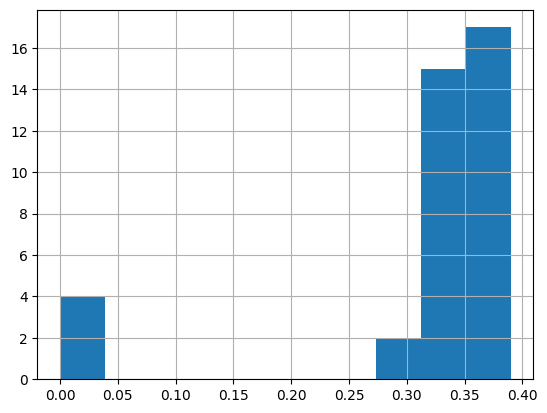

In [28]:
#we should know most of the vocab...
df_deck.query("tags == @clean_story_name").knowledge_score.hist()